# 1. Import and Install Dependencies

In [3]:
import cv2
import numpy as np
import os
import mediapipe as mp
import pandas as pd

from matplotlib import pyplot as plt

# 2. Keypoints using MP Hands

importiamo il modello Hands di MediaPipe

In [4]:
mp_holistic = mp.solutions.holistic
mp_hands = mp.solutions.hands # Hands model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp_drawing_styles = mp.solutions.drawing_styles

funzione di riconoscimento: convertiamo prima l'immagine dal canale BGR (output di OpenCV feed) a quello RGB, necessario per MediaPipe;
alla fine riconvertiamo in BGR

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction with the Holistic/Hands model
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

# 3. Extract Keypoint Function

restituisce il numero dei landmark usati per la parte del corpo specificata

Lavoriamo su ciascun landkmark: 

- creiamo degli array dove memorizzare le sue coordinate (dei landmark)

- Useremo degli array di zero quando una certa parte del corpo non è riconosciuta/presente, per non fare andare in errore il sistema.

**N.B.** usiamo *flatten()* perchè vogliamo un solo array, unidimensionale, perchè ci servirà questo formato per la LSTM; infatti, senza flatten() avremo una matrice, un array bidimensionale (ciascun landmark avrà *x* valori associati)

In [6]:
def extract_keypoints_hands(results, hand_landmarks):
    h = np.array([[res.x, res.y, res.z] for res in hand_landmarks.landmark]).flatten() if results.multi_hand_landmarks else np.zeros(21*3)    
    return h

In [7]:
def extract_keypoints_world_hands(results, hand_landmarks):
    h = np.array([[res.x, res.y, res.z] for res in hand_landmarks.landmark]).flatten() if results.multi_hand_world_landmarks else np.zeros(21*3)    
    return h

come abbiamo detto prima, creiamo un array vuoto (di zeri), per gestire l'errore nel caso in cui una parte del corpo non è riconosciuta.

nello specifico:

res.x, res.y, res.z sono i singoli valori delle coord. per ciascun landmark, che verranno inseriti in un array più grande, ciclando per ogni landmark:

- se non esistono coordinate per i landmark, quindi quella parte del corpo non è riconosciuta, viene creato un array vuoto

### abbiamo estratto i **keypoints** per il frame di interesse, che saranno utili per il riconoscimento dei gesti/segni

# 4. Setup Folders

quali sono i gesti contenuti nel dataset?

In [6]:
labels = np.array(["Photo Frame", "Ok", "Pause", "Mano del Gaucho", "Greeting", "No", "Pinched Fingers", "Applaud", "Heart"])

infatti, i valori assegnati a ogni label (classe) sul dataset sono i seguenti:

- photo frame: 23
- ok: 34
- pause: 36
- mano del gaucho: 38
- greeting: 39
- no: 40
- pinched fingers: 50
- applaud: 52
- heart: 53

In [7]:
labels_num = [23, 34, 36, 38, 39, 40, 50, 52, 53]
label_dict = {23: 0, 34: 1, 36: 2, 38: 3, 39: 4, 40: 5, 50: 6, 52: 7, 53: 8}
label_dict_string = {23: "Photo Frame", 34: "Ok", 36: "Pause", 38: "Mano del Gaucho", 39: "Greeting", 40: "No", 50: "Pinched Fingers", 52: "Applaud", 53: "Heart"}

poichè il dataset è suddiviso nel seguente modo:
- frames 1
    - soggetto x (da 1 a 9)
        - scena x (da 1 a 6)
            - colore
                - rgb x (da 1 a 8)
                    - frames 1
                    - ...
                    - frame n
- frames 2
    - soggetto x (da 10 a 19)
        - ...

essendoci 50 soggetti, 6 scene e 83 gesti diversi, in media avremo che uno stesso soggetto eseguirà gli 83 gesti 6 volte, una volta per ogni diversa scena; quindi uno stesso gesto sarà eseguito circa 50 * 6 = **300** volte e avremo circa **25000** diverse esecuzioni (83 * 6 * 50).

noi siamo interessati solamente a **9** gesti su 83, quindi avremo in totale 9 * 6 * 50 = **2700** esecuzioni diverse, ovvero **300** esecuzioni per ognuno dei 9 gesti.

La cartella rgb contiene diversi video suddivisi già in frame, e in ognuno di essi sono presenti esecuzioni di 10 gesti diversi. Useremo il file .csv *labels-final-revised* per controllare in quali frame sono presenti le esecuzioni dei gesti di interesse. Quali sono e quanti sono?

- soggetto 1
    - scena 1
        - gruppo/rgb x:
            - photo frame, label *23*
                - numero frames: **49**

    - scena 2
        - gruppo/rgb x:
            - photo frame, label *23*
                - numero frame: **30**
    - ...




N.B. Notiamo che la dimensione di ogni frame è la seguente:
- *altezza:* 240 px
- *larghezza:* 320 px

In [8]:
train_subjects = [3, 4, 5, 6, 8, 10, 15, 16, 17, 20, 21, 22, 23, 25, 26, 27, 30, 32, 36, 38, 39, 40, 42, 43, 44, 45, 46, 48, 49, 50]
test_subjects = [2, 9, 11, 14, 18, 19, 28, 31, 41, 47]
valid_subjects = [1, 7, 12, 13, 24, 29, 33, 34, 35, 37]

In [9]:
train_subjects_string = ["subject03", "subject04","subject05","subject06","subject08","subject10","subject15","subject16","subject17","subject20","subject21","subject22","subject23","subject25","subject26","subject27","subject30","subject32","subject36","subject38","subject39","subject40","subject42","subject43","subject44","subject45","subject46","subject48","subject49","subject50"]
test_subjects_string = ["subject02","subject09","subject11","subject14","subject18","subject19","subject28","subject31","subject41","subject47"]
valid_subjects_string = ["subject01","subject07","subject12","subject13","subject24","subject29","subject33","subject34","subject35","subject37"]

prendo tutti i frame di ogni esecuzione di ogni gesto, per ogni scena e per ogni soggetto. Per farlo però, devo prima andare a vedere gli indici dei frame in cui si trovano e memorizzarli in un array:

- prima però dobbiamo eliminare il file *.DS_Store*, illeggibile e inutile:

In [5]:
def remove_file(path):
    try:
        os.remove(os.path.join(path, ".DS_Store"))
    except:
        pass

In [6]:
LABELDIR = r'D:\TMS\dataset\egogesture\labels-final-revised'

for subject in os.listdir(LABELDIR):
    subj_path = os.path.join(LABELDIR, str(subject))
    remove_file(subj_path)

    for scene in os.listdir(subj_path):   
        scene_path = os.path.join(subj_path, str(scene))
        remove_file(scene_path)
    
        for group in os.listdir(scene_path):
            group_path = os.path.join(scene_path, str(group))
            remove_file(group_path)

muovo file/frame in directory diverse...

In [11]:
def initialize_counts():
    
    count_23 = 0
    count_34 = 0
    count_36 = 0
    count_38 = 0
    count_39 = 0
    count_40 = 0
    count_50 = 0
    count_52 = 0
    count_53 = 0

    countlist = [count_23, count_34, count_36, count_38, count_39, count_40, count_50, count_52, count_53]

    return countlist

In [ ]:
import shutil

LABELDIR = r'D:\TMS\dataset\egogesture\labels-final-revised'
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

subj_list = []

list_23 = []
list_34 = []
list_36 = []
list_38 = []
list_39 = []
list_40 = []
list_50 = []
list_52 = []
list_53 = []

for subject in os.listdir(LABELDIR):
    subj_path = os.path.join(LABELDIR, str(subject))      

    countlist = initialize_counts() 

    for scene in os.listdir(subj_path):   
        scene_path = os.path.join(subj_path, str(scene))        
    
        for group in os.listdir(scene_path):
            group_path = os.path.join(scene_path, str(group))
            
            csv = pd.read_csv(group_path, names = ("label", "start_idx", "end_idx"), delimiter = ",") 
            my_csv = csv.query("label in @labels_num")

            if not my_csv.empty: #se c'è corrispondenza
            #prendo ora gli indici di inizio e fine, per ogni gesto
                idx_list = my_csv.values.tolist()
                #print(subject, group, idx_list)   

                for sublist in idx_list:
                    label = sublist[0]
                    countlist[label_dict[label]] += 1
                    #print(label, countlist[label_dict[label]])     
                                   
       # manipolazione per singolo subject   
        
    # questi già fatti
    if not subject == "subject01":
        if not subject == "subject02":
            if not subject == "subject03":
                if not subject == "subject04":
                    if not subject == "subject05": 
                        if not subject == "subject06":   

                            if subject in train_subjects_string:
                                print(subject, ": train")
                            elif subject in test_subjects_string:
                                print(subject, ": test")
                            elif subject in valid_subjects_string:
                                print(subject, ": validation")   

                            subject_fold = subject[7:9]                         
                            if int(subject_fold) < 10:                                
                                subject_fold = subject[8]                                                                       
                            
                            #vediamo per il soggetto X quante occorrenze ci sono per ogni label
                            for label in labels_num:                                
                                
                                label_path = os.path.join(GESTDIR, str(label))
                                print("lab:", label, ",", countlist[label_dict[label]])
                                c = countlist[label_dict[label]]

                                train_path = os.path.join(label_path, "training")   
                                test_path = os.path.join(label_path, "test")   
                                validation_path = os.path.join(label_path, "validation")                              

                                subj_list = os.listdir(label_path) 
                                subj_list.remove("test")
                                subj_list.remove("training")
                                subj_list.remove("validation")
                                subj_list.sort(key = int)                               
                                subj_list = subj_list[0:c]                                
                                print(" ", subj_list) 

                                if subject in train_subjects_string:

                                    for elem in subj_list:
                                        elem_path = os.path.join(label_path, str(elem))                                        
                                        train_subj_path = os.path.join(train_path, subject_fold)
                                        print(train_subj_path)
                                        shutil.move(elem_path, train_subj_path)

                                elif subject in test_subjects_string:
                                    for elem in subj_list:
                                        elem_path = os.path.join(label_path, str(elem))
                                        test_subj_path = os.path.join(test_path, subject_fold)
                                        print(test_subj_path)
                                        shutil.move(elem_path, test_subj_path)
                                    
                                elif subject in valid_subjects_string:
                                    for elem in subj_list:
                                        elem_path = os.path.join(label_path, str(elem))
                                        validation_subj_path = os.path.join(validation_path, subject_fold)
                                        print(validation_subj_path)
                                        shutil.move(elem_path, validation_subj_path)
                                    
    print ("\n")

creo ora folds dei gesti, dove salvaremo ogni video in cui la stessa è performata

In [24]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

for label in labels_num: #per ogni label (per ogni gesto)
    try:
        os.makedirs(os.path.join(GESTDIR, str(label), "validation")) 
        os.makedirs(os.path.join(GESTDIR, str(label), "test"))        
        os.makedirs(os.path.join(GESTDIR, str(label), "training"))        
    except:
        pass #se esistono già, skippa la creazione

creiamo fold dei soggetti di train e test

In [25]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

for label in labels_num: #per ogni label (per ogni gesto)
    path = os.path.join(GESTDIR, str(label))

    for fold in os.listdir(path):
        if str(fold) == "training":
            for subject in train_subjects:                
                try:               
                    os.makedirs(os.path.join(path, "training", str(subject)))
                except:
                    pass #se esistono già, skippa la creazione

        elif str(fold) == "test":
            for subject in test_subjects:
                try:
                    os.makedirs(os.path.join(path, "test", str(subject)))
                except:
                    pass

        elif str(fold) == "validation":
            for subject in valid_subjects:
                try:
                    os.makedirs(os.path.join(path, "validation", str(subject)))
                except:
                    pass

accedo ora direttamente ai frame

In [10]:
def get_group_name(path, group):
    if str(group) == "rgb1":
        return "Group1"
    elif str(group) == "rgb2":
        return "Group2"
    elif str(group) == "rgb3":
        return "Group3"
    elif str(group) == "rgb4":
        return "Group4"
    elif str(group) == "rgb5":
        return "Group5"
    elif str(group) == "rgb6":
        return "Group6"
    elif str(group) == "rgb7":
        return "Group7"
    elif str(group) == "rgb8":
        return "Group8"  

In [18]:
def count_label_occ(countlist, label):
    print(countlist)
    if label == 23:
        countlist[0] += 1
    elif label == 34:
        countlist[1] += 1
    elif label == 36:
        countlist[2] += 1
    elif label == 38:
        countlist[3] += 1
    elif label == 39:
        countlist[4] += 1
    elif label == 40:
        countlist[5] += 1
    elif label == 50:
        countlist[6] += 1
    elif label == 52:
        countlist[7] += 1    
    elif label == 53:
        countlist[8] += 1 

    return countlist

In [122]:
def copy_frames(data_path, label, start_idx, end_idx, countlist):

    GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

    vid = countlist[label_dict[label]]
    path = os.path.join(GESTDIR, str(label), str(vid)) 

    frames = []    
    
    for frame in os.listdir(data_path):
        frame = frame[2:6].lstrip("0")        
        frames.append(frame)

    my_frames = frames[start_idx-1:end_idx]

    for frame in my_frames:
        #aggiungiamo estensione e zeros
        name_frame = frame.zfill(6) + ".jpg"        
        img_path = os.path.join(data_path, name_frame)
        img_array = cv2.imread(img_path) #leggo l'img

        print(img_path)

        #salvo l'img nella directory di interesse        
        os.chdir(path)
        cv2.imwrite(name_frame, img_array)
    

In [116]:
#trovo le label comuni dei gesti che voglio
def read_idx_frame(path, data_path, countlist):      

    csv = pd.read_csv(path, names = ("label", "start_idx", "end_idx"), delimiter = ",") 
    my_csv = csv.query("label in @labels_num")
    
    if not my_csv.empty: #se c'è corrispondenza

        #prendo ora gli indici di inizio e fine, per ogni gesto
        idx_list = my_csv.values.tolist()      
        
        for sublist in idx_list:
            label = sublist[0]
            start_idx = sublist[1]
            end_idx = sublist[2]  

            print("\nsublist:", sublist)  

            #creo dict per incrementare le occorrenze di ogni gesto            
            countlist[label_dict[label]] += 1    
            
            #vedo quanti frame ci sono per ogni occorrenza di ogni gesto  
            num_frames = (end_idx + 1) - start_idx
            print("numero frame per label:", label, "=", num_frames)
            
            #prendo i frame indicati e li copio nelle cartelle apposite
            #copy_frames(data_path, label, start_idx, end_idx, countlist)  
            
    else:
        print("- no corrispondenza") 
        
    return countlist   

creo le folds per i video

In [26]:
def create_video_folds(countlist):

    labels_dict = dict(zip(labels_num, countlist)) #trasformo in dizionario: {key: labels_num, value: num_video}
    #print("\ndict:", labels_dict)

    for label in labels_dict:
        path = os.path.join(GESTDIR, str(label))
        #print(path)
        #print(labels_dict[label])

        for i in range(1, labels_dict[label]+1):
            try:
                os.makedirs(os.path.join(GESTDIR, str(label), str(i)))
            except:
                pass       

tengo conto ogni volta di due percorsi:
- uno per accedere ai frame
- l'altro per accedere ai .csv dove sono contenuti gli indici dei frame da estrarre

In [ ]:
LABELDIR = r'D:\TMS\dataset\egogesture\labels-final-revised' #per gli indici nei .csv
DATADIR = r"D:\TMS\dataset\egogesture" #per i frames

#tengo conto ogni volta di due percorsi:
# - uno per accedere ai frame (DATADIR + ...)
# - l'altro per accedere ai .csv (LABELDIR + ...)

countlist = initialize_counts()

for frame_set in os.listdir(DATADIR):
    if not str(frame_set) == "labels-final-revised" and not str(frame_set) == "gestures":
        print("\nnome insieme frame:", frame_set)
        data_frame_path = os.path.join(DATADIR, str(frame_set))
        
        for subject in os.listdir(data_frame_path):
            print("\nsubject:", subject)
            data_subj_path = os.path.join(data_frame_path, str(subject))
            label_subj_path = os.path.join(LABELDIR, str(subject))
            subject = str(subject)[0:9] #tolgo l'estensione dal nome  
            
            for scene in os.listdir(data_subj_path): 
                print("\n\nscene:", scene)
                data_scene_path = os.path.join(data_subj_path, str(scene)) 
                label_scene_path = os.path.join(label_subj_path, str(scene))
                scene = str(scene)[0:7] #tolgo l'estensione dal nome

                for type in os.listdir(data_scene_path):                    

                    if str(type) == "Color":  #seleziono la sottocartella "Color"
                        print("frames type:", type)
                        data_color_path = os.path.join(data_scene_path, str(type))
                        
                        for group in os.listdir(data_color_path):   
                            print("\ngroup/rgb:", group)      
                            data_group_path = os.path.join(data_color_path, str(group))   

                            if not str(group) == "rgb9": #TODO if provvisorio, aggiustare
                                group = get_group_name(label_scene_path, group)
                                label_group_path = os.path.join(label_scene_path, (str(group)+ ".csv"))                                

                                #questa funzione dovrebbe ritornare gli indici di inizio e fine dell'esecuzione di un singolo gesto..                   
                                countlist = read_idx_frame(label_group_path, data_group_path, countlist) #..problema: ci sono più gesti per ogni singolo gruppo
                                print("countlist atm:", countlist)

print("\ncountlist:", countlist)
#create_video_folds(countlist)
#come scritto sopra, ho circa quasi 300 esecuzioni (video) per ogni gesto

creo fold keypoints per ogni video della fold del gesto in questione

In [26]:
for label in os.listdir(GESTDIR):
    label_path = os.path.join(GESTDIR, label)

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            for vid in os.listdir(subj_path):
                try: 
                    os.makedirs(os.path.join(subj_path, vid, "keypoints"))
                except:
                    pass #se esistono già, skippa la creazione

# 5. Collect Keypoint Values from the dataset for Training and Testing

##### ❗❗ Estrarremo i keypoints dai frame di ciascun video presente nel **dataset** *Egogesture*

- Prima però devo normalizzare il numero di frame per ogni video: ci sono video che hanno pochi frame, altri che ne hanno molti di più

    - a tal proposito, devo **generare nuovi frame** per quei video che non raggiungono una soglia specifica, un *treshold*

In [6]:
def get_num_frames(path):   

    # restituisce tutti gli elementi nel path indicato, nel nostro caso tutti i frame per il video specificato con il suo path
    frames_4_video = os.listdir(path)        
    num_frames = len(frames_4_video) - 1 #togliamo 1 perchè non consideriamo la fold dei keypoints
    print("Numero frame per questo video:", num_frames)

    return num_frames

In [7]:
def create_name_frame(frame, num_to_add, ext):
    
    name_frame = frame[0:6].lstrip("0")
    new_name_frame = int(name_frame) + num_to_add
    new_name_frame = (str(new_name_frame) + ext).zfill(10) 

    print("new name frame:", new_name_frame, ", old name frame:", frame)   

    return new_name_frame

In [8]:
TRESHOLD = 30

In [55]:
def change_name_frame(num_frames, list_frames, path, ext):
    num_to_add = TRESHOLD - num_frames
    print("aggiungere frame di numero:", num_to_add)

    #devo cambiare il nome dei frame successivi a questo
    # è il frame da copiare, il "mediano"
    num_mid_frame = round(num_frames/2) #indice
    
    num_frames_to_pick = num_frames - num_mid_frame
    #print("the last N frames to change, N:", num_frames_to_pick)

    #dall'ultimo al successivo di mid_frame
    frame_to_change = list_frames[-num_frames_to_pick:] #list slicing
    frame_to_change = sorted(frame_to_change, reverse = True)

    print("to change:", frame_to_change)

    for frame in frame_to_change:
        #print(frame)
        frame_path = os.path.join(path, frame)
        new_frame = create_name_frame(frame, num_to_add, ext)                        
        new_frame_path = os.path.join(path, new_frame)  
        print("new frame path:", new_frame_path)                   
        os.rename(frame_path, new_frame_path)

genero nuovi frame a partire da quello centrale, inserendoli successivamente ad esso, cambiando il nome dei vecchi frame ad esso conseguenti, a parire dall'ultimo, per evitare problemi di sovrascrittura di nomi

In [ ]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'
TRESHOLD = 35

all_num_frames = 0

for label in os.listdir(GESTDIR):
    label_path = os.path.join(GESTDIR, label)

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            for vid in os.listdir(subj_path):

                count = 0

                path = os.path.join(subj_path, vid) 
                print("\nPercorso video:", path) 
                #os.chdir(path)  

                list_frame = os.listdir(path)
                list_frame.remove("keypoints")

                num_frames = get_num_frames(path) 
                all_num_frames += num_frames
    
                if num_frames < TRESHOLD:     
                    
                    # cambio i nomi degli ultimi N frame per "far posto" ai nuovi
                    change_name_frame(num_frames, list_frame, path, ".jpg") 

                    num_mid_frame = round(num_frames/2) #indice
                    mid_frame = list_frame[num_mid_frame - 1]
                    print("the mid frame:", mid_frame)   

                    path_mid_frame = os.path.join(path, mid_frame)     
                    
                    while num_frames < TRESHOLD:
                    # genero ora i nuovi frame
                    
                        count += 1

                        #copio il mid frame
                        img_array = cv2.imread(path_mid_frame)
                        new_frame_name = create_name_frame(mid_frame, count, ".jpg")
                        new_frame_path = os.path.join(path, new_frame_name)
                        print(new_frame_path)

                        #cv2.imwrite(new_frame_path, img_array) #salvo nella fold il "nuovo" frame, ovvero una copia del mid frame                
                                                        
                        num_frames += 1
                        print("numero frame aggiornato:", num_frames) 
                else:
                    print("il video ha già almeno 30 frame")                    
               

print("\nNumero medio di frame per video:", all_num_frames/2632)   


per evitare di riestrarre tutti i keypoints, faccio la stessa cosa (genarazione di copie) per i keypoints, per quei video che non hanno corrispondezza fra lunghezza frame e cartella keypoints 

In [ ]:
import shutil

GESTDIR = r'D:\TMS\dataset\egogesture\gestures'
TRESHOLD = 30

for label in os.listdir(GESTDIR):
    label_path = os.path.join(GESTDIR, label)

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            for vid in os.listdir(subj_path):

                count = 0

                vid_path = os.path.join(subj_path, vid)
                print("\n",vid_path)
                num_frames = get_num_frames(vid_path)

                kp_path = os.path.join(vid_path, "keypoints")
                kp_fold = os.listdir(kp_path)
                kp_fold_len = len(kp_fold)

                print(num_frames, kp_fold_len)

                if kp_fold_len != num_frames:
                    print("tocca duplicare i keypoints")
                    
                    # come prima "shifto" i nomi
                    #change_name_frame(kp_fold_len, kp_fold, kp_path, ".npy")

                    num_to_add = TRESHOLD - kp_fold_len
                    num_mid_array = round(kp_fold_len/2) #indice
                    mid_npy_array = kp_fold[num_mid_array - 1]
                    print("the mid npy_array:", mid_npy_array)   

                    path_mid_array = os.path.join(kp_path, mid_npy_array)     
                    
                    while kp_fold_len < TRESHOLD:
                    # genero ora i nuovi npy_array
                    
                        count += 1

                        #copio il mid npy_array
                        copied_array = np.copy(np.load(path_mid_array))                

                        new_array_name = create_name_frame(mid_npy_array, count, ".npy")
                        new_array_path = os.path.join(kp_path, new_array_name)
                        print(new_array_path)

                        np.save(new_array_path, copied_array) #salvo nella fold il "nuovo" npy_array, ovvero una copia del mid npy_array                
                                                        
                        kp_fold_len += 1
                        print("numero npy_array aggiornato:", kp_fold_len) 


                else:
                    print("il video aveva già tutti i kp estratti")  

elimino i kp esistenti

In [10]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

for label in os.listdir(GESTDIR):
    label_path = os.path.join(GESTDIR, label)

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            for vid in os.listdir(subj_path):
          
                vid_path = os.path.join(subj_path, vid)               

                kp_path = os.path.join(vid_path, "keypoints")
                kp_fold = os.listdir(kp_path)

                for elem in kp_fold:
                    frame_path = os.path.join(kp_path, elem)
                    #print(frame_path)
                    os.remove(frame_path)

----------------------------------------

        #TODO tutti blocchi di codice simili

##### Duplico i frame esistenti flippandoli, in modo da avere sia la prospettiva della mano dx che sx

- prima però rinomino tutti i video in modo da averli tutti con nomi di interi consecutivi (1, 2, 3, ...) così da poter aggiungere agevolmente gli altri video flippati

In [ ]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

for label in os.listdir(GESTDIR):
    label_path = os.path.join(GESTDIR, label)

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            for num, vid in enumerate(sorted(os.listdir(subj_path), key=int)):
                vid_path = os.path.join(subj_path, vid)
                subj_fold_len = len(os.listdir(subj_path))   

                new_vid_name = str(num + 1)
                new_vid_path = os.path.join(subj_path, new_vid_name)                

                os.rename(vid_path, new_vid_path)               

- e inoltre devo prima creare altre cartelle dove salvare questi frame flippati

In [ ]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

for label in os.listdir(GESTDIR):
    label_path = os.path.join(GESTDIR, label)

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            list_vid = os.listdir(subj_path)            
            last_vid = list_vid[-1]            

            for num in range(1, len(list_vid) + 1):
                new_vid_fold  = str(int(last_vid) + num)               

                try:                    
                    os.makedirs(os.path.join(subj_path, new_vid_fold))
                except:
                    pass
                

- ora posso duplicare i video flippando i frame contenuti in ognuno di essi

In [12]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

for label in os.listdir(GESTDIR):
    label_path = os.path.join(GESTDIR, label)

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            vid_len = len(os.listdir(subj_path))

            for vid in sorted(os.listdir(subj_path), key=int):
                vid_path = os.path.join(subj_path, vid)
                list_frame = os.listdir(vid_path)

                try:
                    list_frame.remove("keypoints")
                except: pass

                if list_frame: #se non vuota
                    for frame in list_frame:
                        img_array = cv2.imread(os.path.join(vid_path, frame))
                        flipped_img = cv2.flip(img_array, 1)

                        to_save_vid = str(int(vid) + int(vid_len/2))
                        to_save_path = os.path.join(subj_path, to_save_vid, frame)

                        cv2.imwrite(to_save_path, flipped_img)

                        #print("frame:", frame,"from:", vid_path,", to:", to_save_path)                

-----------------------------------

estraggo e memorizzo i keypoints

In [11]:
def get_num_keypoints(path):
    keypoints_path = os.path.join(path, 'keypoints')
    num_keypoints = len(os.listdir(keypoints_path)) #indica quanti keypoints sono stati estratti 
    
    return num_keypoints 

In [12]:
def get_and_append_img(path, img, all_frames):

    img_num = img[0:6] #prendo i primi N char, per non avere l'estensione nel nome quando salvo dopo
    img_path = os.path.join(path, img)
    img_array = cv2.imread(img_path)  # convert to array
    #print("\npath:", img_path)                    
    all_frames.append(img)

    return img_array, img_num

In [13]:
def get_num_frames(path):   

    # restituisce tutti gli elementi nel path indicato, nel nostro caso tutti i frame per il video specificato con il suo path
    frames_4_video = os.listdir(path)        
    num_frames = len(frames_4_video) - 1 #togliamo 1 perchè non consideriamo la fold dei keypoints
    print("Numero frame per questo video:", num_frames)

    return num_frames

estraggo i keypoints da ogni video, sia per soggetti di training che di test

In [19]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

videos_list = []
train_videos = []
test_videos = []
valid_videos = []

- HOLISTIC

In [ ]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:

    for label in os.listdir(GESTDIR):
        label_path = os.path.join(GESTDIR, label)

        for set_fold in os.listdir(label_path):
            sets_path = os.path.join(label_path, set_fold)
            
            for subj in os.listdir(sets_path):
                subj_path = os.path.join(sets_path, subj)

                for vid in os.listdir(subj_path):

                    all_frames = []

                    print(vid)
                    vid_path = os.path.join(subj_path, vid)

                    frames_4_video = os.listdir(vid_path)
            
                    num_frames = get_num_frames(vid_path)        
                    num_keypoints = get_num_keypoints(vid_path) #indica quanti keypoints sono stati estratti 

                    if num_keypoints != num_frames:           

                        for frame in frames_4_video:

                            if not frame == "keypoints":

                                img_array, img_num = get_and_append_img(vid_path, frame, all_frames)                                
                                keypoints = detect_and_extract(img_array, holistic)
                                print(keypoints)

                                # salvo i keypoints su disco
                                npy_path = os.path.join(vid_path, "keypoints", img_num)
                                #np.save(npy_path, keypoints)
                                    
                    else:
                        print("keypoints già estratti")
                        videos_list.append(vid)

                        if str(subj) in train_subjects_string:
                            train_videos.append(vid)
                        elif str(subj) in test_subjects_string:
                            test_videos.append(vid)
                        elif str(subj) in valid_subjects_string:
                            valid_videos.append(vid)
    

- HANDS

In [56]:
def add_mid_frames(num_frames, list_frames, vid_path, count):    

    change_name_frame(num_frames, list_frames, vid_path, ".jpg")

    num_mid_frame = round(num_frames/2) #indice
    mid_frame = list_frames[num_mid_frame - 1]  
    print("\nmid frame", mid_frame)

    path_mid_frame = os.path.join(vid_path, mid_frame)
    #print("path mid frame:", path_mid_frame)     

    print("\ncreo ora i nuovi frame-copia\n")
    while num_frames < TRESHOLD:
    # genero ora i nuovi frame

        count += 1

        #copio il mid frame
        img_array = cv2.imread(path_mid_frame)
        new_frame_name = create_name_frame(mid_frame, count, ".jpg")
        new_frame_path = os.path.join(vid_path, new_frame_name)
        print("new path:", new_frame_path)

        cv2.imwrite(new_frame_path, img_array) #salvo nella fold il "nuovo" frame, ovvero una copia del mid frame                
                                        
        num_frames += 1
        print("numero frame aggiornato:", num_frames)

riduco la lunghezza dei video prendendo solamente una percentuale dei frame 

In [199]:
def reduce_list_frames(list_frames):
    
    num_frames = len(list_frames)

    if num_frames > 30:
        print("num frames:", num_frames, "> 30")
        
        if num_frames < 60:
            reduced_list_frames = list_frames[:30] #i primi 30
        else:
            print("> 60")

            percentage = int(5/100 * num_frames)
            print("5% di num_frames:", percentage)

            first_list = list_frames[:percentage]
            last_list = list_frames[-percentage:]

            idx1 = percentage
            idx2 = num_frames - percentage

            step = 2

            while True: #do while
                
                middle_list = list_frames[idx1:idx2:step]
                reduced_list_frames = first_list + middle_list + last_list
                step += 1
                
                if len(reduced_list_frames) <= 30:
                    break

            #elimino poi i frames non comuni

    else: reduced_list_frames = list_frames

    return reduced_list_frames

In [270]:
def change_all_name_frames(list_frames, path):
    
    i = 0
    for elem in list_frames:
        print(elem)
        old_name_path = os.path.join(path, str(elem))
        name_frame = "006" + str(i).zfill(3) + ".jpg"
        new_name_path = os.path.join(path, name_frame)
        print("new name path", new_name_path)
        os.rename(old_name_path, new_name_path)
        i += 1

In [14]:
def checkConsecutive(l):
    return sorted(l) == list(range(min(l), max(l)+1))

------------------------------------

##### Trasformazione delle coordinate dei keypoints estratti

- poichè *EgoGesture* è un dataset che contiene frame di gesti ripresi da una telecamera frontale, quindi da un punto di visto "egocentrico", in prima persona, trasformiamo le coordinate dei keypoints estratti da ciascun frame:

    - *perchè ?* **->** vogliamo gesti che siano ripresi da una visuale in terza persona, quindi come se ci ritrovassimo **difronte** la telecamera
    - *come ?* **->** una volta estratti i punti, li ruotiamo di 180° attorno all'asse y, **simulando** così la terza persona

In [13]:
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import math

In [12]:
# Funzione che dato un vettore di coordinate (un punto), l'asse attorno a cui ruotare, e l'angolo (in radianti) di rotazione ..
# .. restituisce il vettore "trasformato": ruotato di 180° e traslato all'indietro (su asse z) 

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

funzione che estrae e manipola nello spazio 3D i keypoints

- **N.B.** ogni mano riconosciuta ha 21 keypoints che la *rappresentano*

In [54]:
def detect_and_transform_keypoints(results):
     
    first_hand_keypoints = np.zeros(21*3)
    second_hand_keypoints = np.zeros(21*3)

    #TODO aggiustare perchè if lo fa già extract_keypoints
    
    # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
    for num, hand_landmarks in enumerate(results.multi_hand_world_landmarks): 

        new_res = []  # conterrà le nuove coord trasformate
        new_hand_landmarks = []
        
        # trasformo le coordinate di ogni punto
        for res in hand_landmarks.landmark:
            point = np.array([res.x, res.y, res.z]).flatten()

            # sposto più indietro, sull'asse z, i keypoints                
            point[2] += 0.5
            if (point[2] > 1):
                #print("z: ", point[2])
                point[2] = 0.9

            # ruoto keypoints attorno ..
            axis = [0, 1, 0] # .. all'asse y ..
            theta = np.pi # .. di 180 gradi | in radianti: pi-greco
            point_rotated = np.dot(rotation_matrix(axis, theta), point)
            #print("before:", point, "| after:", point_rotated)

            new_res.append(landmark_pb2.NormalizedLandmark(
                x = point_rotated[0], y = point_rotated[1], z = point_rotated[2]))            
        
        # creo la nuova "mappa" di keypoint per l'attuale frame 
        # N.B. ogni mano riconosciuta ha 21 keypoints che la "rappresentano"
        new_hand_landmarks = landmark_pb2.NormalizedLandmarkList(
            landmark = [
                new_res[0],
                new_res[1],
                new_res[2],
                new_res[3],
                new_res[4],
                new_res[5],
                new_res[6],
                new_res[7],
                new_res[8],
                new_res[9],
                new_res[10],
                new_res[11],
                new_res[12],
                new_res[13],
                new_res[14],
                new_res[15],
                new_res[16],
                new_res[17],
                new_res[18],
                new_res[19],
                new_res[20],                    
            ]
        )      
            
        if num == 0: # prima mano riconosciuta 
            first_hand_keypoints = extract_keypoints_world_hands(results, new_hand_landmarks)
            print("\nrh shape:", first_hand_keypoints)

        if num == 1: # seconda mano riconosciuta
            second_hand_keypoints = extract_keypoints_world_hands(results, new_hand_landmarks)
            print("\nlh shape:", second_hand_keypoints)

        mp_drawing.plot_landmarks(new_hand_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)

    keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints]) 

    return keypoints, new_hand_landmarks                          

qui, per ogni frame di ogni video, chiamo la funzione che mi estrae i relativi keypoints e li salvo nella sub-fold "keypoints", presente all'interno della fold di ogni video

In [24]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'
TRESHOLD = 30

with mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

    for label in os.listdir(GESTDIR):
        label_path = os.path.join(GESTDIR, label)

        print(label)

        for set_fold in os.listdir(label_path):
            sets_path = os.path.join(label_path, set_fold)
            
            for subj in os.listdir(sets_path):
                subj_path = os.path.join(sets_path, subj)

                for vid in os.listdir(subj_path):
                    
                    count = 0
                    all_frames = []

                    vid_path = os.path.join(subj_path, vid)
                    list_frames = os.listdir(vid_path)
                    list_frames.remove("keypoints")

                    num_frames = len(list_frames)

                    if num_frames > 30:
                        reduced_list_frames = list_frames[:30]

                    elif num_frames < 30:
                        print("ALLARME < 30", num_frames)
                        print(vid_path)
                        #add_mid_frames(num_frames, list_frames, vid_path, count)

                    else: reduced_list_frames = list_frames

                    #print("\nnum_frames:", len(reduced_list_frames))

                    num_keypoints = get_num_keypoints(vid_path) #indica quanti keypoints sono stati estratti 

                    if num_keypoints != TRESHOLD:          
                        #print("num_kp != 30,", num_keypoints, "\n") 

                        for frame in reduced_list_frames:

                            img_array, img_num = get_and_append_img(vid_path, frame, all_frames)   
                            image_h, results = mediapipe_detection(img_array, hands)
                            annotated_image = image_h.copy()

                            # se almeno una mano è riconosciuta nell'attuale frame ..
                            if results.multi_hand_landmarks:
                                keypoints = detect_and_transform_keypoints(results)                                

                            # altrimenti creo un vettore di zeri
                            else:
                                #print("\nnessun kp trovato")
                                first_hand_keypoints = np.zeros(21*3)
                                second_hand_keypoints = np.zeros(21*3)
                                keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])

                            #print("both hands kp shape:", keypoints.shape)                                    
                            npy_path = os.path.join(vid_path, "keypoints", img_num)
                            #print(keypoints)
                            np.save(npy_path, keypoints)

                    # se tutti i keypoints sono estratti estratti per quel video, procedo a salvarlo
                    else:
                        print("keypoints già estratti\n", vid_path)
                        videos_list.append(vid)

                        if str(subj) in train_subjects_string:
                            train_videos.append(vid_path)
                        elif str(subj) in test_subjects_string:
                            test_videos.append(vid_path)
                        elif str(subj) in valid_subjects_string:
                            valid_videos.append(vid_path)    

23
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\1
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\10
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\11
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\12
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\2
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\3
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\4
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\5
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\6
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\7
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\8
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\9
keypoints già estratti
 D:\TMS\dataset\egogest

In [20]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'
TRESHOLD = 30

with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands:

    for label in os.listdir(GESTDIR):
        label_path = os.path.join(GESTDIR, label)

        print(label)

        for set_fold in os.listdir(label_path):
            sets_path = os.path.join(label_path, set_fold)
            
            for subj in os.listdir(sets_path):
                subj_path = os.path.join(sets_path, subj)

                for vid in os.listdir(subj_path):
                    
                    count = 0
                    all_frames = []

                    vid_path = os.path.join(subj_path, vid)
                    list_frames = os.listdir(vid_path)
                    list_frames.remove("keypoints")

                    num_frames = len(list_frames)

                    if num_frames > 30:
                        reduced_list_frames = list_frames[:30]

                    elif num_frames < 30:
                        print("ALLARME < 30", num_frames)
                        print(vid_path)
                        #add_mid_frames(num_frames, list_frames, vid_path, count)

                    else: reduced_list_frames = list_frames

                    #print("\nnum_frames:", len(reduced_list_frames))

                    num_keypoints = get_num_keypoints(vid_path) #indica quanti keypoints sono stati estratti 

                    if num_keypoints != TRESHOLD:          
                        #print("num_kp != 30,", num_keypoints, "\n") 

                        for frame in reduced_list_frames:

                            img_array, img_num = get_and_append_img(vid_path, frame, all_frames)   
                            image_h, results = mediapipe_detection(img_array, hands)
                            annotated_image = image_h.copy()

                            first_hand_keypoints = np.zeros(21*3)
                            second_hand_keypoints = np.zeros(21*3)
    
                            #TODO aggiustare perchè if lo fa già extract_keypoints
                            if results.multi_hand_landmarks:
                                
                                # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
                                for num, hand_landmarks in enumerate(results.multi_hand_landmarks):   

                                    if num == 0: # prima mano riconosciuta 
                                        first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                                        #print("\nrh shape:", first_hand_keypoints.shape)

                                    if num == 1: # seconda mano riconosciuta
                                        second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                                        #print("\nlh shape:", second_hand_keypoints.shape)

                                keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])                               

                            else:
                                #print("nessun kp trovato")
                                keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])

                            #print("both hands kp shape:", keypoints.shape)                                    
                            npy_path = os.path.join(vid_path, "keypoints", img_num)
                            np.save(npy_path, keypoints)

                    else:
                        print("keypoints già estratti\n", vid_path)
                        videos_list.append(vid)

                        if str(subj) in train_subjects_string:
                            train_videos.append(vid_path)
                        elif str(subj) in test_subjects_string:
                            test_videos.append(vid_path)
                        elif str(subj) in valid_subjects_string:
                            valid_videos.append(vid_path)    

23
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\1
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\10
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\11
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\12
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\2
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\3
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\4
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\5
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\6
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\7
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\8
keypoints già estratti
 D:\TMS\dataset\egogesture\gestures\23\test\subject02\9
keypoints già estratti
 D:\TMS\dataset\egogest

In [21]:
print(len(videos_list), len(train_videos), len(test_videos), len(valid_videos))

5264 3148 1076 1040


abbiamo quindi **5264** video totali, suddivisi in:
- **3148** di *Training*
- **1076** di *Test*
- **1040** di *Validation*

----------------------------------------------------------------------------------------------------------------------------

#### **TEST**: provo img singola

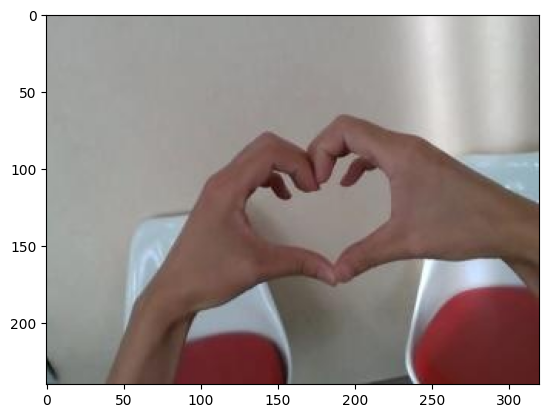

In [8]:
DATADIR2 = r"D:\TMS\dataset\egogesture\gestures\53\training\subject08\5"

# OTTENGO I FRAME    
path_test = os.path.join(DATADIR2, '001561.jpg')  # create path (...\Color\rgb1)
frame_test = cv2.imread(path_test)  # convert to array
plt.imshow(cv2.cvtColor(frame_test, cv2.COLOR_BGR2RGB))      

In [9]:
height, width = frame_test.shape[:2]
print("height:", height, "| width:", width)

height: 240 | width: 320


holistic

In [ ]:
# ESTRAGGO I KEYPOINTS DA UN FRAME
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    image, results = mediapipe_detection(frame_test, holistic)
    draw_styled_landmarks(image, results)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  

    keypoints = extract_keypoints(results) #memorizzo i keypoints estratti    
    print(keypoints)

hands

        Normalized X gives 0 to 1 where x-origin is origin of the image x-coordinate
        Normalized Y gives 0 to 1 where y-origin is origin of the image y-coordinate
        Normalized Z where z-origin is relative to the wrist z-origin. I.e if Z is positive, the z-la ndmark coordinate is out of the page with respect to the wrist. Z is negative, the z-landmark coordinate is into the page with respect of the wrist.


1st hand kp: [ 2.81166017e-01  7.22892642e-01  8.77960758e-07  3.47774565e-01
  7.37784266e-01 -8.97008404e-02  4.23443377e-01  6.86220586e-01
 -1.26872405e-01  5.04706979e-01  6.73198998e-01 -1.43779501e-01
  5.65771222e-01  6.99590743e-01 -1.52442694e-01  3.57840866e-01
  4.84704375e-01 -1.00966074e-01  4.52984750e-01  3.73741746e-01
 -1.16836183e-01  5.15948951e-01  4.10982788e-01 -1.13821872e-01
  5.39161861e-01  4.63629305e-01 -1.03766963e-01  3.40514332e-01
  4.63333935e-01 -5.23827560e-02  4.45755422e-01  3.49625349e-01
 -6.71364218e-02  5.08725882e-01  3.95411074e-01 -6.39247596e-02
  5.28324246e-01  4.53256279e-01 -5.39915115e-02  3.39106262e-01
  4.62161362e-01 -7.11969705e-03  4.29492325e-01  3.68080467e-01
 -1.82819553e-02  4.86155152e-01  4.04327542e-01 -2.22885050e-02
  5.05867004e-01  4.52710778e-01 -1.82417724e-02  3.47031206e-01
  4.70153481e-01  3.18465382e-02  4.16183025e-01  3.96634996e-01
  1.79468468e-02  4.64795351e-01  4.13532078e-01  9.85438097e-03
  4.8871699

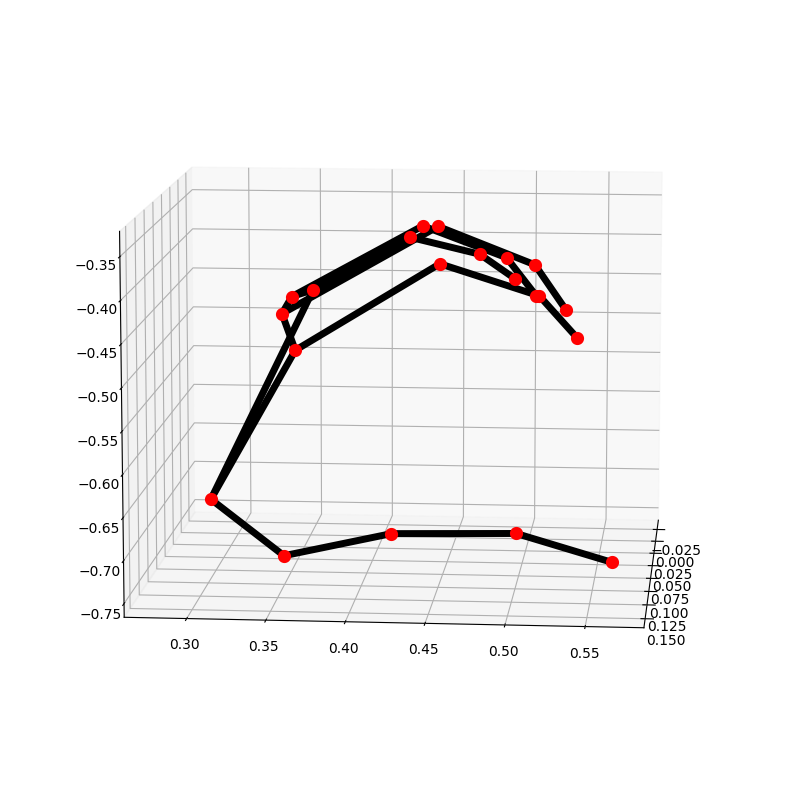


2nd hand kp: [ 9.07726407e-01  5.61734855e-01  1.79087554e-08  8.35123479e-01
  6.07999921e-01 -7.83597976e-02  7.32589662e-01  6.18440270e-01
 -1.03069350e-01  6.50349855e-01  6.50523305e-01 -1.08393811e-01
  5.94434202e-01  6.94551885e-01 -1.02987640e-01  7.22804189e-01
  3.82131636e-01 -6.70027509e-02  6.20712399e-01  3.08118641e-01
 -8.41568559e-02  5.66627204e-01  3.61669332e-01 -9.12981108e-02
  5.47022700e-01  4.32821929e-01 -8.73371512e-02  7.35011458e-01
  3.68180782e-01 -1.60867367e-02  6.29325390e-01  3.12903315e-01
 -2.16752533e-02  5.72207928e-01  3.75334680e-01 -1.97514184e-02
  5.54877281e-01  4.41008061e-01 -1.31409410e-02  7.47405589e-01
  3.75644624e-01  2.95220017e-02  6.52106225e-01  3.44045132e-01
  2.56138109e-02  6.00051045e-01  3.91887188e-01  2.17823032e-02
  5.78789532e-01  4.44106102e-01  2.54774038e-02  7.52768457e-01
  3.91179293e-01  7.05164596e-02  6.74212396e-01  3.71837705e-01
  6.93986118e-02  6.30812466e-01  4.06580359e-01  6.87806979e-02
  6.1177551

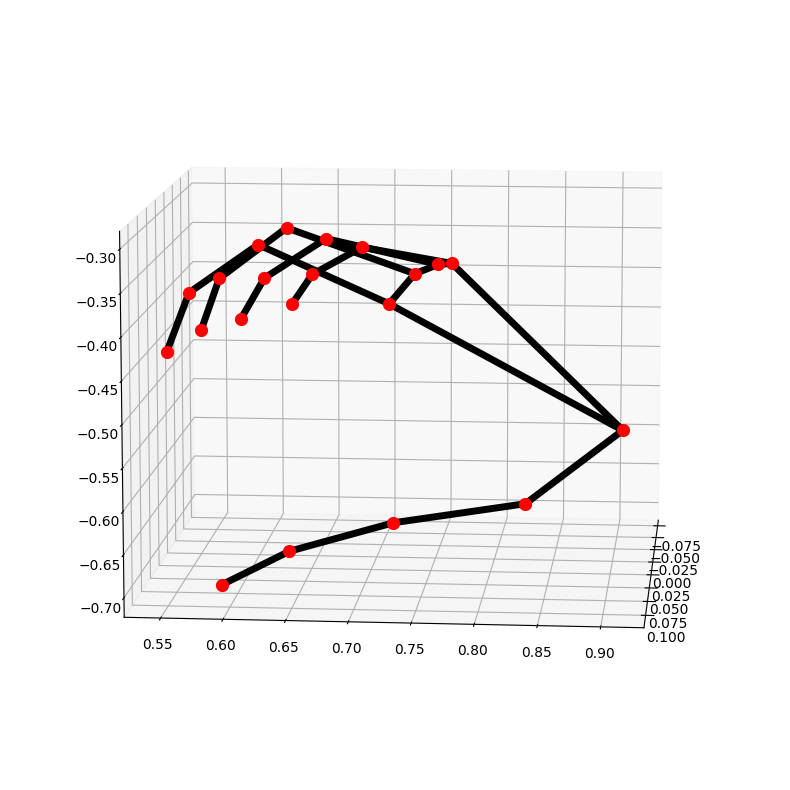


both hands kp: [ 2.81166017e-01  7.22892642e-01  8.77960758e-07  3.47774565e-01
  7.37784266e-01 -8.97008404e-02  4.23443377e-01  6.86220586e-01
 -1.26872405e-01  5.04706979e-01  6.73198998e-01 -1.43779501e-01
  5.65771222e-01  6.99590743e-01 -1.52442694e-01  3.57840866e-01
  4.84704375e-01 -1.00966074e-01  4.52984750e-01  3.73741746e-01
 -1.16836183e-01  5.15948951e-01  4.10982788e-01 -1.13821872e-01
  5.39161861e-01  4.63629305e-01 -1.03766963e-01  3.40514332e-01
  4.63333935e-01 -5.23827560e-02  4.45755422e-01  3.49625349e-01
 -6.71364218e-02  5.08725882e-01  3.95411074e-01 -6.39247596e-02
  5.28324246e-01  4.53256279e-01 -5.39915115e-02  3.39106262e-01
  4.62161362e-01 -7.11969705e-03  4.29492325e-01  3.68080467e-01
 -1.82819553e-02  4.86155152e-01  4.04327542e-01 -2.22885050e-02
  5.05867004e-01  4.52710778e-01 -1.82417724e-02  3.47031206e-01
  4.70153481e-01  3.18465382e-02  4.16183025e-01  3.96634996e-01
  1.79468468e-02  4.64795351e-01  4.13532078e-01  9.85438097e-03
  4.88716

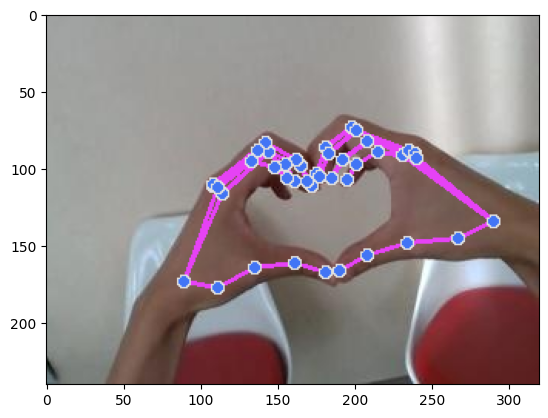

In [36]:
# ESTRAGGO I KEYPOINTS DA CIASCUN FRAME
with mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5) as hands:
    image_h_test, results_test = mediapipe_detection(frame_test, hands)
    
    annotated_image_test = image_h_test.copy()

    first_hand_keypoints_test = np.zeros(21*3)
    second_hand_keypoints_test = np.zeros(21*3)
    
    if results_test.multi_hand_landmarks:

        for num, hand_landmarks_test in enumerate(results_test.multi_hand_landmarks):        

            mp_drawing.draw_landmarks(     
                annotated_image_test,
                hand_landmarks_test,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                )

            if num == 0:   
                first_hand_keypoints_test = extract_keypoints_hands(results_test, hand_landmarks_test)
                print("\n1st hand kp:", first_hand_keypoints_test)
            if num == 1:
                second_hand_keypoints_test = extract_keypoints_hands(results_test, hand_landmarks_test)
                print("\n2nd hand kp:", second_hand_keypoints_test)
            
            mp_drawing.plot_landmarks(
            hand_landmarks_test, mp_hands.HAND_CONNECTIONS, azimuth=5)

        keypoints_test = np.concatenate([first_hand_keypoints_test, second_hand_keypoints_test])

    else: keypoints_test = np.zeros(21*6)  

    print("\nboth hands kp:", keypoints_test, "\nwith shape:", keypoints_test.shape)   

    plt.imshow(cv2.cvtColor(annotated_image_test, cv2.COLOR_BGR2RGB))  

In [28]:
import math

image_width = 320
image_height = 240 

# restituiscono le coordinate dei pixel dell'img
x_px = min(math.floor(0.28 * image_width), image_width - 1) # simile a: x * image_width | y * image_height
y_px = min(math.floor(0.72 * image_height), image_height - 1)

normalized_x = x_px / image_width
normalized_y = y_px / image_height

print(x_px, y_px, normalized_x)

89 172 0.278125
57


        multi_hand normalizzati        
        
        1st hand kp: [ 2.81166017e-01  7.22892642e-01  8.77960758e-07  3.47774565e-01
        7.37784266e-01 -8.97008404e-02  4.23443377e-01  6.86220586e-01
        -1.26872405e-01  5.04706979e-01  6.73198998e-01 -1.43779501e-01
        5.65771222e-01  6.99590743e-01 -1.52442694e-01  3.57840866e-01
        4.84704375e-01 -1.00966074e-01  4.52984750e-01  3.73741746e-01
        -1.16836183e-01  5.15948951e-01  4.10982788e-01 -1.13821872e-01
        5.39161861e-01  4.63629305e-01 -1.03766963e-01  3.40514332e-01
        4.63333935e-01 -5.23827560e-02  4.45755422e-01  3.49625349e-01
        -6.71364218e-02  5.08725882e-01  3.95411074e-01 -6.39247596e-02
        5.28324246e-01  4.53256279e-01 -5.39915115e-02  3.39106262e-01
        4.62161362e-01 -7.11969705e-03  4.29492325e-01  3.68080467e-01
        -1.82819553e-02  4.86155152e-01  4.04327542e-01 -2.22885050e-02
        5.05867004e-01  4.52710778e-01 -1.82417724e-02  3.47031206e-01
        4.70153481e-01  3.18465382e-02  4.16183025e-01  3.96634996e-01
        1.79468468e-02  4.64795351e-01  4.13532078e-01  9.85438097e-03
        4.88716990e-01  4.43888456e-01  1.07146092e-02]

        
        multi_hand_world non normalizzati

        1st hand kp: [-1.79589465e-02  5.46023324e-02  5.75566925e-02 -3.10329720e-03
        5.64572476e-02  1.67761035e-02  1.99293345e-02  5.08583710e-02
        -9.59049538e-03  4.08069007e-02  5.32311574e-02 -4.63469177e-02
        5.81749007e-02  6.46284670e-02 -6.81140050e-02 -8.43394082e-04
        5.67655079e-03 -2.73888167e-02  1.35179730e-02 -4.64664167e-03
        -2.68890765e-02  3.55650783e-02 -8.86119902e-04 -7.49270059e-03
        4.77670953e-02  4.79579717e-03  1.47536257e-02 -2.82268832e-03
        -1.56633009e-03 -4.63804090e-03  1.73767079e-02 -1.95604190e-02
        2.48738914e-04  3.57697308e-02 -1.60572790e-02  1.87921636e-02
        4.57282588e-02 -6.34760968e-03  4.05673832e-02  2.54119653e-03
        -3.90630262e-03  1.68688558e-02  1.61738023e-02 -1.40009392e-02
        2.09725723e-02  3.33629958e-02 -1.16300182e-02  3.58761773e-02
        4.23914045e-02 -6.69489056e-03  5.03054373e-02  2.00247043e-03
        8.97822320e-05  4.87035848e-02  1.23611046e-02 -9.04941466e-03
        4.95480224e-02  2.88267415e-02 -1.05170310e-02  5.41303232e-02
        3.70010249e-02 -8.24688934e-03  6.21961989e-02]

In [33]:
def detect_and_transform_keypoints(results):
     
    first_hand_keypoints = np.zeros(21*3)
    second_hand_keypoints = np.zeros(21*3)

    #TODO aggiustare perchè if lo fa già extract_keypoints
    
    # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
    for num, hand_landmarks in enumerate(results.multi_hand_landmarks): 

        new_res = []  # conterrà le nuove coord trasformate
        new_hand_landmarks = []
        
        # trasformo le coordinate di ogni punto
        for res in hand_landmarks.landmark:
            point = np.array([res.x, res.y, res.z]).flatten()

            point[0] *= 320
            point[1] *= 240 

            # sposto più indietro, sull'asse z, i keypoints                
            point[2] += 0.5
            if (point[2] > 1):
                #print("z: ", point[2])
                point[2] = 0.9

            # ruoto keypoints attorno ..
            axis = [0, 1, 0] # .. all'asse y ..
            theta = np.pi # .. di 180 gradi | in radianti: pi-greco
            point_rotated = np.dot(rotation_matrix(axis, theta), point)
            print("before:", point, "| after:", point_rotated)

            new_res.append(landmark_pb2.NormalizedLandmark(
                x = point_rotated[0], y = point_rotated[1], z = point_rotated[2]))            
        
        # creo la nuova "mappa" di keypoint per l'attuale frame 
        # N.B. ogni mano riconosciuta ha 21 keypoints che la "rappresentano"
        new_hand_landmarks = landmark_pb2.NormalizedLandmarkList(
            landmark = [
                new_res[0],
                new_res[1],
                new_res[2],
                new_res[3],
                new_res[4],
                new_res[5],
                new_res[6],
                new_res[7],
                new_res[8],
                new_res[9],
                new_res[10],
                new_res[11],
                new_res[12],
                new_res[13],
                new_res[14],
                new_res[15],
                new_res[16],
                new_res[17],
                new_res[18],
                new_res[19],
                new_res[20],                    
            ]
        )      
            
        if num == 0: # prima mano riconosciuta 
            first_hand_keypoints = extract_keypoints_world_hands(results, new_hand_landmarks)
            print("\nrh shape:", first_hand_keypoints)

        if num == 1: # seconda mano riconosciuta
            second_hand_keypoints = extract_keypoints_world_hands(results, new_hand_landmarks)
            print("\nlh shape:", second_hand_keypoints)

        mp_drawing.plot_landmarks(new_hand_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)

    keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints]) 

    return keypoints, new_hand_landmarks                          

before: [ 89.97312546 173.49423409   0.50000088] | after: [-89.97312546 173.49423409  -0.50000088]
before: [111.28786087 177.06822395   0.41029916] | after: [-111.28786087  177.06822395   -0.41029916]
before: [135.50188065 164.69294071   0.37312759] | after: [-135.50188065  164.69294071   -0.37312759]
before: [161.50623322 161.56775951   0.3562205 ] | after: [-161.50623322  161.56775951   -0.3562205 ]
before: [181.04679108 167.90177822   0.34755731] | after: [-181.04679108  167.90177822   -0.34755731]
before: [114.50907707 116.32905006   0.39903393] | after: [-114.50907707  116.32905006   -0.39903393]
before: [144.95512009  89.69801903   0.38316382] | after: [-144.95512009   89.69801903   -0.38316382]
before: [165.1036644   98.63586903   0.38617813] | after: [-165.1036644    98.63586903   -0.38617813]
before: [172.5317955  111.27103329   0.39623304] | after: [-172.5317955   111.27103329   -0.39623304]
before: [108.96458626 111.20014429   0.44761724] | after: [-108.96458626  111.2001442

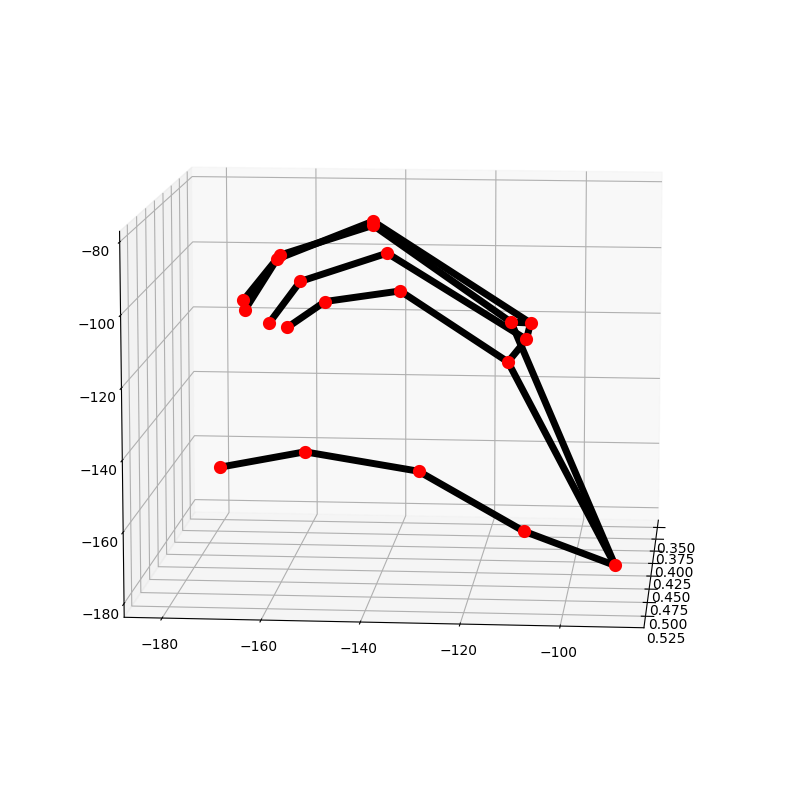

before: [290.47245026 134.81636524   0.50000002] | after: [-290.47245026  134.81636524   -0.50000002]
before: [267.2395134 145.919981    0.4216402] | after: [-267.2395134  145.919981    -0.4216402]
before: [234.42869186 148.4256649    0.39693065] | after: [-234.42869186  148.4256649    -0.39693065]
before: [208.11195374 156.12559319   0.39160619] | after: [-208.11195374  156.12559319   -0.39160619]
before: [190.21894455 166.69245243   0.39701236] | after: [-190.21894455  166.69245243   -0.39701236]
before: [231.29734039  91.71159267   0.43299725] | after: [-231.29734039   91.71159267   -0.43299725]
before: [198.62796783  73.94847393   0.41584314] | after: [-198.62796783   73.94847393   -0.41584314]
before: [181.32070541  86.80063963   0.40870189] | after: [-181.32070541   86.80063963   -0.40870189]
before: [175.0472641  103.87726307   0.41266285] | after: [-175.0472641   103.87726307   -0.41266285]
before: [235.20366669  88.36338758   0.48391326] | after: [-235.20366669   88.36338758  

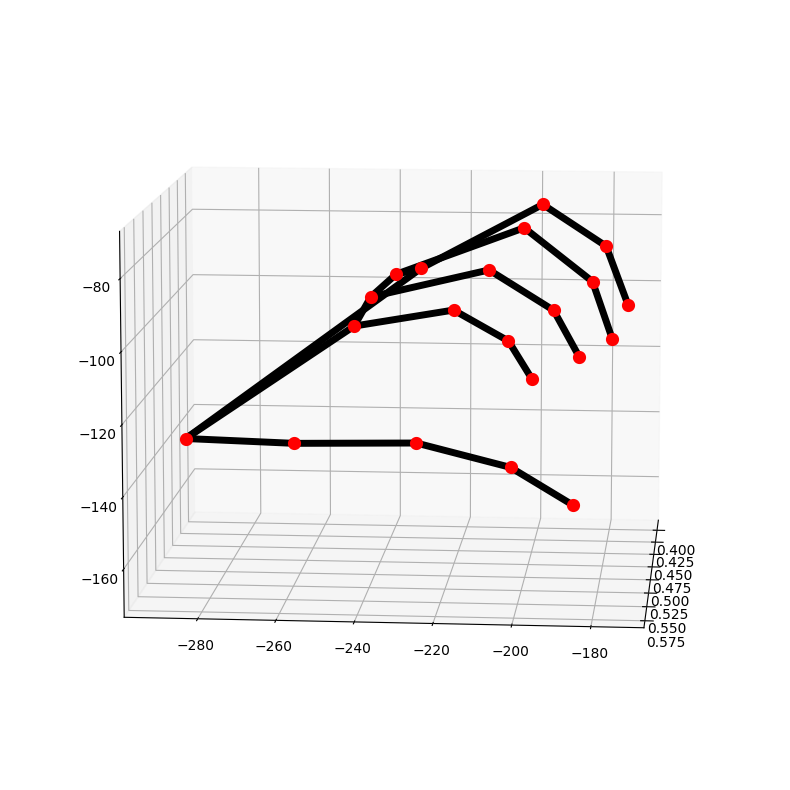


both hands kp: [ -89.97312927  173.49423218   -0.50000089 -111.28785706  177.06822205
   -0.41029915 -135.50187683  164.69294739   -0.37312761 -161.50622559
  161.56776428   -0.35622051 -181.04678345  167.90177917   -0.34755731
 -114.50907898  116.32904816   -0.39903393 -144.9551239    89.69802094
   -0.38316381 -165.10366821   98.63587189   -0.38617814 -172.53179932
  111.27103424   -0.39623305 -108.96458435  111.20014191   -0.44761723
 -142.64173889   83.91007996   -0.43286359 -162.7922821    94.89865875
   -0.43607524 -169.06375122  108.7815094    -0.4460085  -108.51400757
  110.91872406   -0.49288031 -137.43754578   88.33930969   -0.48171803
 -155.56964111   97.03861237   -0.4777115  -161.87744141  108.65058899
   -0.48175824 -111.04998779  112.83683777   -0.53184652 -133.17857361
   95.19239807   -0.51794684 -148.73451233   99.24769592   -0.50985438
 -156.38943481  106.53322601   -0.51071459 -290.47244263  134.81636047
   -0.5        -267.23950195  145.91998291   -0.42164022 -234

In [34]:
# ESTRAGGO I KEYPOINTS DA CIASCUN FRAME
with mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5) as hands:
    image_h_test, results_test = mediapipe_detection(frame_test, hands)
    
    annotated_image_test = image_h_test.copy()

    first_hand_keypoints_test = np.zeros(21*3)
    second_hand_keypoints_test = np.zeros(21*3)
    
    if results_test.multi_hand_landmarks:
        keypoints_test, new_hand_lm = detect_and_transform_keypoints(results_test)
        
    else: keypoints_test = np.zeros(21*6)  

    print("\nboth hands kp:", keypoints_test, "\nwith shape:", keypoints_test.shape)  

    #mp_drawing.plot_landmarks(new_hand_lm, mp_hands.HAND_CONNECTIONS, azimuth=5)

    #plt.imshow(cv2.cvtColor(annotated_image_test, cv2.COLOR_BGR2RGB)) 

In [77]:
np.zeros(21*3).shape

(63,)

#### abbiamo **21** keypoints per ogni mano, ma con dimensione effettiva di **63** tenendo conto delle tre coordinate dello spazio **3D** *(x, y, z)*

- ##### avremo quindi, considerando entrambe le mani, **42** keypoints con dimensione totale **126**
    - ##### *126* sarà proprio l'*input shape* del nostro modello di Deep Learning  

----------------------------------------------------------------------------------------------------------------------------

# 6. Preprocess Data and Create Labels and Features

In [22]:
#from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

strutturiamo i dati fin ora raccolti, inserendoli in un unico array

qui cicliamo separatamente per i video di training e test, avendoli già divisi:

In [23]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

In [24]:
def insert_all_in_array():

    train_videos_array = [] # X (feature input)
    test_videos_array = []
    valid_videos_array = [] 

    for label in os.listdir(GESTDIR):
        label_path = os.path.join(GESTDIR, label)
        print(label)

        for set_fold in os.listdir(label_path):
            sets_path = os.path.join(label_path, set_fold)
            
            for subj in os.listdir(sets_path):
                subj_path = os.path.join(sets_path, subj)

                for vid in os.listdir(subj_path):
                    vid_path = os.path.join(subj_path, vid)

                    if subj in train_subjects_string:
                        train_window = []
                    elif subj in test_subjects_string:
                        test_window = []
                    elif subj in valid_subjects_string:
                        valid_window = []

                    kp_path = os.path.join(vid_path, "keypoints")
                    kp_fold = os.listdir(kp_path)

                    for kp in kp_fold:
                        npy_path = os.path.join(kp_path, kp)
                        res = np.load(npy_path)
                        #print("\n", npy_path, "\n", res)

                        if subj in train_subjects_string:   
                            train_window.append(res)                       
                        elif subj in test_subjects_string:        
                            test_window.append(res)                    
                        elif subj in valid_subjects_string:                            
                            valid_window.append(res)

                    if subj in train_subjects_string:   
                        train_videos_array.append(train_window)                       
                    elif subj in test_subjects_string:        
                        test_videos_array.append(test_window)                          
                    elif subj in valid_subjects_string:                            
                        valid_videos_array.append(valid_window)       

    return train_videos_array, test_videos_array, valid_videos_array

avremo così array di array di array: 
- per primo un grande array per ogni tipologia di video (train, test e validation) che contiene altri array
- tali array rappresentano i relativi video, che a loro volta contengono altri array
- questi array contengono i keypoints estratti da ogni frame di ogni video

In [25]:
train_videos_array, test_videos_array, valid_videos_array = insert_all_in_array()

23
34
36
38
39
40
50
52
53


In [28]:
print(np.array(train_videos_array).shape)
print(np.array(test_videos_array).shape)
print(np.array(valid_videos_array).shape)

(3148, 30, 126)
(1076, 30, 126)
(1040, 30, 126)


In [26]:
BASEDIR = r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics"
ego_dir = os.path.join(BASEDIR, "mytempfiles", "egogesture_files")

In [29]:
np.save(os.path.join(ego_dir, "test_videos_array"), test_videos_array)
np.save(os.path.join(ego_dir, "train_videos_array"), train_videos_array)
np.save(os.path.join(ego_dir, "valid_videos_array"), valid_videos_array)

In [9]:
train_videos_array = np.load(os.path.join(ego_dir,"train_videos_array.npy"))
test_videos_array = np.load(os.path.join(ego_dir,"test_videos_array.npy"))
valid_videos_array = np.load(os.path.join(ego_dir,"valid_videos_array.npy"))

In [37]:
train_videos_array[0][0] #prime parentesi quadre per accedere al (primo) video, le seconde per accedere al (primo) frame 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [30]:
X_train = np.array(train_videos_array)
X_test = np.array(test_videos_array)

In [12]:
X_train

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.24759132,  0.83457923, -0.50000095, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.19251977,  0.61148512, -0.50000095, ...,  

In [31]:
X_train.shape

(3148, 30, 126)

##### devo creare file/dataframe che associ ogni video alla sua label, per quelli di test, train e validation

In [41]:
def apply_label(vid, label, videos_labels):

    #print("label:", label, "dict:", label_dict[label])
    videos_labels[label_dict[label]].append(vid)
       
    return videos_labels

In [32]:
GESTDIR = r"D:\TMS\dataset\egogesture\gestures"

#TODO: soluzione artigianale ma cambiare non si può vedere

train_videos_23 = []
train_videos_34 = []
train_videos_36 = []
train_videos_38 = []
train_videos_39 = []
train_videos_40 = []
train_videos_50 = []
train_videos_52 = []
train_videos_53 = []

test_videos_23 = []
test_videos_34 = []
test_videos_36 = []
test_videos_38 = []
test_videos_39 = []
test_videos_40 = []
test_videos_50 = []
test_videos_52 = []
test_videos_53 = []

valid_videos_23 = []
valid_videos_34 = []
valid_videos_36 = []
valid_videos_38 = []
valid_videos_39 = []
valid_videos_40 = []
valid_videos_50 = []
valid_videos_52 = []
valid_videos_53 = []

# mi serve a contare il numero dei video per ogni label
videos_labels_train = [train_videos_23, train_videos_34, train_videos_36, train_videos_38, train_videos_39, train_videos_40, train_videos_50, train_videos_52, train_videos_53]
videos_labels_test = [test_videos_23, test_videos_34, test_videos_36, test_videos_38, test_videos_39, test_videos_40, test_videos_50, test_videos_52, test_videos_53]
videos_labels_validation = [valid_videos_23, valid_videos_34, valid_videos_36, valid_videos_38, valid_videos_39, valid_videos_40, valid_videos_50, valid_videos_52, valid_videos_53]

for label in os.listdir(GESTDIR):
    label_path = os.path.join(GESTDIR, label)

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            for vid in os.listdir(subj_path):         
                
                if subj in train_subjects_string:
                    apply_label(vid, int(label), videos_labels_train)
                elif subj in test_subjects_string:
                    apply_label(vid, int(label), videos_labels_test)
                elif subj in valid_subjects_string:
                    apply_label(vid, int(label), videos_labels_validation)

#in videos_labels_x[i] ci sono tutti i video per ogni label i-esima
sum_train = 0
for i in range(0, 9):
    #print("\ntrain:", labels_num[i], sorted(videos_labels_train[i], key = int))
    print(labels_num[i], len(videos_labels_train[i]))
    sum_train += len(videos_labels_train[i])
print("sum train:", sum_train, "\n")

sum_test = 0
for i in range(0, 9):
    #print("\ntest:", labels_num[i], sorted(videos_labels_test[i], key = int))
    #print(labels_num[i], len(videos_labels_test[i]))
    sum_test += len(videos_labels_test[i])
print("sum test:", sum_test, "\n")

sum_valid = 0
for i in range(0, 9):
    #print("\ntest:", labels_num[i], sorted(videos_labels_valid[i], key = int))
    print(labels_num[i], len(videos_labels_validation[i]))
    sum_valid += len(videos_labels_validation[i])
print("sum valid:", sum_valid, "\n")


NameError: name 'apply_label' is not defined

vediamo il *numero di video* per ogni classe/*label* e come sono divisi fra gli insiemi di training, test e validation:
- **23**: 584
    - *training*: 350
    - *test*: 120
    - *validation*: 114
- **34**: 588
    - *training*: 352
    - *test*: 120
    - *validation*: 116
- **36**: 586
    - *training*: 350
    - *test*: 120
    - *validation*: 116
- **38**: 580
    - *training*: 346
    - *test*: 118
    - *validation*: 116
- **39**: 582
    - *training*: 350
    - *test*: 118
    - *validation*: 114
- **40**: 586
    - *training*: 350
    - *test*: 120
    - *validation*: 116
- **50**: 590
    - *training*: 354
    - *test*: 120
    - *validation*: 116
- **52**: 582
    - *training*: 346
    - *test*: 120
    - *validation*: 116
- **53**: 586
    - *training*: 350
    - *test*: 120
    - *validation*: 116

creo le label da associare ad ogni video e da dare in input alla rete neurale LSTM:
- poichè i video sono ordinati per label, mi basta creare un dataframe dove concateno il nome di tutte le label per x volte
    - ovvero per tutti i video che ho per quella classe (scritto sopra)

In [33]:
# uso le label categoriche al posto di quelle numeriche (TODO SUPERFLUO, ma c'è codice già scritto sotto...)
train_label_23 = [labels[0]] * 350
train_label_34 = [labels[1]] * 352
train_label_36 = [labels[2]] * 350
train_label_38 = [labels[3]] * 346
train_label_39 = [labels[4]] * 350
train_label_40 = [labels[5]] * 350
train_label_50 = [labels[6]] * 354
train_label_52 = [labels[7]] * 346
train_label_53 = [labels[8]] * 350

# creata lista che contiene tutte le occorrenze di ogni label, già ordinate (come scritto sopra)
train_labels_list = train_label_23+train_label_34+train_label_36+train_label_38+train_label_39+train_label_40+train_label_50+train_label_52+train_label_53

# creo dataframe
train_label_df = pd.DataFrame(train_labels_list, columns=["label"])
print(train_label_df)

            label
0     Photo Frame
1     Photo Frame
2     Photo Frame
3     Photo Frame
4     Photo Frame
...           ...
3143        Heart
3144        Heart
3145        Heart
3146        Heart
3147        Heart

[3148 rows x 1 columns]


In [34]:
# uso le label categoriche al posto di quelle numeriche (TODO SUPERFLUO, ma c'è codice già scritto sotto...)
test_label_23 = [labels[0]] * 120
test_label_34 = [labels[1]] * 120
test_label_36 = [labels[2]] * 120
test_label_38 = [labels[3]] * 118
test_label_39 = [labels[4]] * 118
test_label_40 = [labels[5]] * 120
test_label_50 = [labels[6]] * 120
test_label_52 = [labels[7]] * 120
test_label_53 = [labels[8]] * 120

# creata lista che contiene tutte le occorrenze di ogni label, già ordinate (come scritto sopra)
test_labels_list = test_label_23+test_label_34+test_label_36+test_label_38+test_label_39+test_label_40+test_label_50+test_label_52+test_label_53

# creo dataframe
test_label_df = pd.DataFrame(test_labels_list, columns=["label"])
print(test_label_df)

            label
0     Photo Frame
1     Photo Frame
2     Photo Frame
3     Photo Frame
4     Photo Frame
...           ...
1071        Heart
1072        Heart
1073        Heart
1074        Heart
1075        Heart

[1076 rows x 1 columns]


In [17]:
# uso le label categoriche al posto di quelle numeriche (TODO SUPERFLUO, ma c'è codice già scritto sotto...)
validation_label_23 = [labels[0]] * 114
validation_label_34 = [labels[1]] * 116
validation_label_36 = [labels[2]] * 116
validation_label_38 = [labels[3]] * 116
validation_label_39 = [labels[4]] * 114
validation_label_40 = [labels[5]] * 116
validation_label_50 = [labels[6]] * 116
validation_label_52 = [labels[7]] * 116
validation_label_53 = [labels[8]] * 116

# creata lista che contiene tutte le occorrenze di ogni label, già ordinate (come scritto sopra)
validation_labels_list = validation_label_23+validation_label_34+validation_label_36+validation_label_38+validation_label_39+validation_label_40+validation_label_50+validation_label_52+validation_label_53

# creo dataframe
validation_label_df = pd.DataFrame(validation_labels_list, columns=["label"])
print(validation_label_df)

            label
0     Photo Frame
1     Photo Frame
2     Photo Frame
3     Photo Frame
4     Photo Frame
...           ...
1035        Heart
1036        Heart
1037        Heart
1038        Heart
1039        Heart

[1040 rows x 1 columns]


In [14]:
labels = np.array(["Photo Frame", "Ok", "Pause", "Mano del Gaucho", "Greeting", "No", "Pinched Fingers", "Applaud", "Heart"])

In [35]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label_train = le.fit_transform(train_label_df["label"]) 
label_test = le.fit_transform(test_label_df["label"])

In [36]:
label_train = sorted(label_train)
label_test = sorted(label_test)

In [ ]:
label_train

trasformo feature categoriche in feature numeriche (One Hot Encoding)

In [37]:
y_train = to_categorical(label_train).astype(int)
y_test = to_categorical(label_test).astype(int)

In [38]:
print(y_train.shape)
print(y_test.shape) # 9 sono le classi

(3148, 9)
(1076, 9)


# 7. Build and Train LSTM Neural Network

Addestriamo la rete neurale (ricorrente) **LSTM**: 

- perchè usare MediaPipe Holistic + una rete neurale LSTM?
    - occorrono *meno dati*
    - più *veloce* nell'addestramento
    - riconoscimento più *veloce* <- RN più *semplice*

In [39]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
from keras.layers import Dropout

**TensorBoard** ci offre una web app per monitorare il nostro modello: addestramento, accuratezza, ... 

In [40]:
BASEDIR = r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics"

In [41]:
log_dir = os.path.join(BASEDIR, "Logs", "Egogesture")
tb_callback = TensorBoard(log_dir=log_dir)

In [42]:
# il modello Sequential ci permette di aggiungere layer in maniera organizzata e facile
model = Sequential()

#tre layer LSTM
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape = (30, 126))) #64 unità
model.add(LSTM(128, return_sequences=True, activation='relu')) #return_sequences è necessario per il passaggio di dati al layer successivo
model.add(LSTM(64, return_sequences=False, activation='relu'))

#droppiamo casualmente dei nodi
#model.add(Dropout(0.5))

#tre layer Dense
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(labels.shape[0], activation='softmax')) #distribuzione di probabilità che assegna ad ogni azione una certa prob.

Compiliamo il modello, usando:

- loss function: "categorical cross entropy"
    - è obbligatoria per classificazione multi-classe

In [45]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [46]:
model_temp = model.fit(X_train, y_train, epochs = 150, callbacks=[tb_callback])

Epoch 1/150
99/99 [==============================] - 17s 71ms/step - loss: 2.0573 - categorical_accuracy: 0.2554
Epoch 2/150
99/99 [==============================] - 6s 61ms/step - loss: 1.5964 - categorical_accuracy: 0.4285
Epoch 3/150
99/99 [==============================] - 6s 59ms/step - loss: 1.2723 - categorical_accuracy: 0.5654
Epoch 4/150
99/99 [==============================] - 6s 60ms/step - loss: 1.1169 - categorical_accuracy: 0.6267
Epoch 5/150
99/99 [==============================] - 6s 60ms/step - loss: 0.9179 - categorical_accuracy: 0.6836
Epoch 6/150
99/99 [==============================] - 6s 60ms/step - loss: 0.8584 - categorical_accuracy: 0.7046
Epoch 7/150
99/99 [==============================] - 6s 61ms/step - loss: 0.8064 - categorical_accuracy: 0.7243
Epoch 8/150
99/99 [==============================] - 6s 61ms/step - loss: 0.8044 - categorical_accuracy: 0.7278
Epoch 9/150
99/99 [==============================] - 6s 61ms/step - loss: 0.7736 - categorical_accuracy

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            48896     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 9)                 297       
                                                                 
Total params: 203,657
Trainable params: 203,657
Non-trai

# 8. Make Predictions

In [48]:
res = model.predict(X_test) #prendo tutte le predizioni dall'insieme di test
# res[0]: significa che prendo la prima prediction (quindi la prediction della prima azione presente in X_test)

34/34 [==============================] - 1s 22ms/step


poichè ad ogni azione è associata una probabilità, la mia predizione sarà quella che avrà probabilità **maggiore** fra esse

In [42]:
labels[np.argmax(res[5])] #qual'è l'azione con il più altro valore di probabilità associato?

'Photo Frame'

prendo la label della 4a azione: vedo quindi il *ground truth*

In [43]:
labels[np.argmax(y_test[5])]

'Photo Frame'

ovviamente, se le due azioni **coincidono** significa che il modello ha una **buona accuracy**

# 9. Save Weights

In [71]:
model.save(os.path.join(BASEDIR, "models_action", 'egoactions.h5'))

In [ ]:
del model

In [27]:
model.load_weights(os.path.join(BASEDIR, "models_action", 'egoactions.h5'))

# 10. Evaluation using Confusion Matrix and Accuracy

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [50]:
yhat = model.predict(X_test)

34/34 [==============================] - 1s 22ms/step


In [51]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [52]:
accuracy_score(ytrue, yhat)

0.8503717472118959

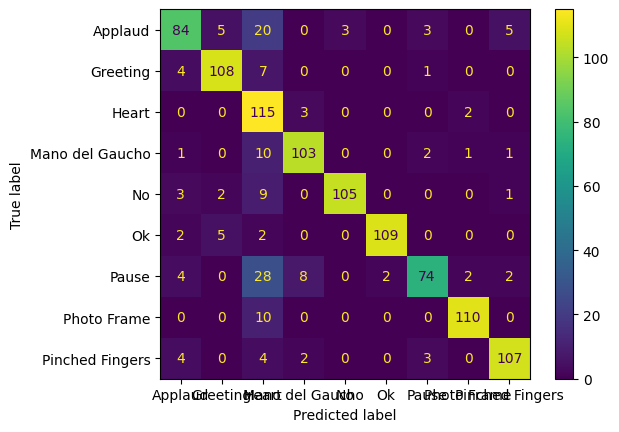

In [53]:
ConfusionMatrixDisplay.from_predictions(labels[ytrue], labels[yhat])

# 11. Test in Real Time

In [54]:
colors = [(245,117,16), (117,245,16), (16,117,245), (121, 91, 45), (45, 84, 45), (56, 15, 26), (90, 204, 100), (136, 137, 136), (21, 16, 56)]
def prob_viz(res, labels, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 90+num*40), (int(prob*100), 60+num*40), colors[num], -1)
        cv2.putText(output_frame, labels[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [81]:
res.shape

(1076, 9)

In [55]:
# 1. New detection variables
sequence = []
predictions = []
gesto = ""
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5) as hands:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        if not ret:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue
        
        # Make detections
        image, results = mediapipe_detection(frame, hands)
        print(results)        
        print("which hand?", results.multi_handedness)

        first_hand_keypoints = np.zeros(21*3)
        second_hand_keypoints = np.zeros(21*3)
    
        if results.multi_hand_landmarks:
            for num, hand_landmarks in enumerate(results.multi_hand_landmarks):        

                mp_drawing.draw_landmarks(     
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                    )
                
                if num == 0:   
                    first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                    #print("\n1st hand kp:", first_hand_keypoints_test)
                if num == 1:
                    second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                    #print("\n2nd hand kp:", second_hand_keypoints_test)

            keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])    

        else: 
            keypoints = np.zeros(21*6)
            print("no detect")
                        
        # 2. Prediction logic
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(labels[np.argmax(res)])
            predictions.append(np.argmax(res))
                       
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold:                     
                    gesto = labels[np.argmax(res)]
             
            # Viz probabilities
            image = prob_viz(res, labels, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(gesto), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? [classification {
  index: 0
  score: 0.9430224299430847
  label: "Left"
}
]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? [classification {
  index: 0
